C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\i

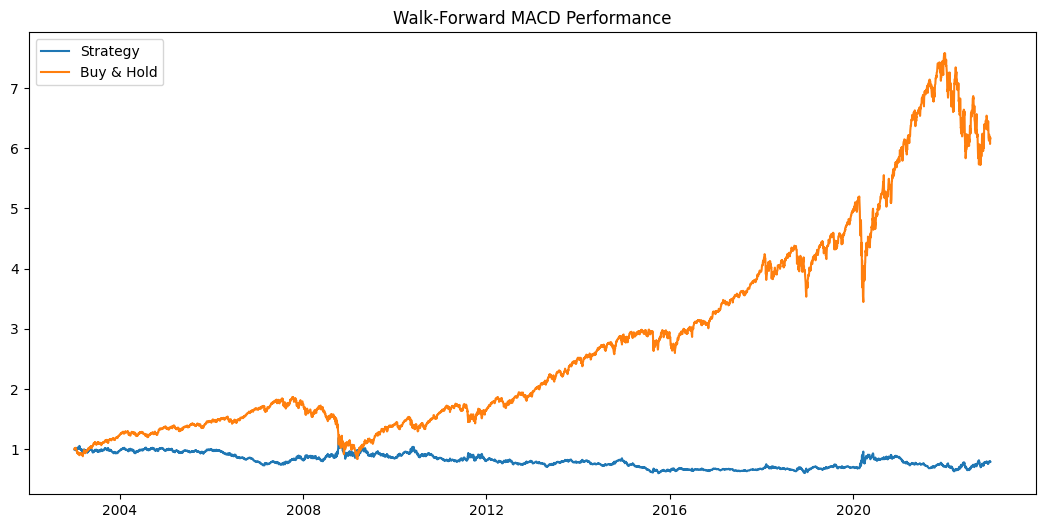

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

asset_list = [
    "SPY", "QQQ", "DIA",
    "EWJ", "EEM", "VGK",
    "TLT", "IEF", "BND",
    "GLD", "SLV", "USO",
    "EURUSD=X", "JPY=X", "AUDUSD=X",
    "BTC-USD", "ETH-USD"
]
MACD_FAST = 12
MACD_SLOW = 26
MACD_SIGNAL = 9

def get_data(ticker):
    df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
    df = df[['Close']].dropna()
    return df

def apply_strategy(df, fast=MACD_FAST, slow=MACD_SLOW, signal=MACD_SIGNAL):
    df = df.copy()
    df[f'{fast}_EMA'] = df['Close'].ewm(span=fast, adjust=False).mean()
    df[f'{slow}_EMA'] = df['Close'].ewm(span=slow, adjust=False).mean()
    df['MACD'] = df[f'{fast}_EMA'] - df[f'{slow}_EMA']
    df['MACD_Signal'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
    
    df['signal'] = 0
    df['MACD_Strategy'] = np.where(df['MACD'] > df['MACD_Signal'], 1, -1)   # short
    df['signal'] = df['MACD_Strategy']
    df['signal'] = df['signal'].shift(1)                         # trade next day
    df['signal'].fillna(0, inplace=True)

    # daily returns
    df['ret'] = df['Close'].pct_change().fillna(0)

    # strategy returns
    df['strategy_ret'] = df['signal'] * df['ret']

    return df[['signal','strategy_ret', 'ret']]


def walk_forward(df, train_years=3, test_years=1):

    df = df.copy()
    results = []

    start = df.index.min()

    while True:
        train_start = start
        train_end = train_start + pd.DateOffset(years=train_years)
        test_end = train_end + pd.DateOffset(years=test_years)

        # break if test window exceeds data
        if test_end > df.index.max():
            break

        # slice windows
        train = df[(df.index >= train_start) & (df.index < train_end)]
        test = df[(df.index >= train_end) & (df.index < test_end)]

        # warm-up buffer for MACD (100 days)
        warmup = df[(df.index >= train_start - pd.DateOffset(days=200)) &
                    (df.index < train_start)]

        # train + test combined for MA calculation
        combined = pd.concat([warmup, train, test])

        # apply strategy
        window_results = apply_strategy(combined)

        # keep only test window results
        window_results = window_results.loc[test.index]

        results.append(window_results)

        # move forward
        start = start + pd.DateOffset(years=test_years)

    final = pd.concat(results)
    return final

ticker = "SPY"
df = get_data(ticker)

results = walk_forward(df, train_years=3, test_years=1)

# cumulative returns
strategy_curve = (1 + results['strategy_ret']).cumprod()
buyhold_curve = (1 + results['ret']).cumprod()

plt.figure(figsize=(13,6))
plt.plot(strategy_curve, label="Strategy")
plt.plot(buyhold_curve, label="Buy & Hold")
plt.title("Walk-Forward MACD Performance")
plt.legend()
plt.show()


In [7]:
def run_strategy_on_asset(ticker):
    df = get_data(ticker)
    results = walk_forward(df)
    return results.dropna()

In [ ]:
from fredapi import Fred

fred_key = '(your fred api key)'
fred = Fred(api_key=fred_key)


In [9]:
RISK_FREE_RATE = fred.get_series(series_id='TB3MS', observation_start = '2000-01-01', observation_end='2024-01-01').iloc[-1]

def compute_performance_metrics(df, risk_free_rate=RISK_FREE_RATE):
    df = df.copy()
    
    # Make sure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    init_equity = 10000
    
    # Correct equity curve calculation
    df['equity'] = init_equity * (1 + df['strategy_ret']).cumprod()
    
    # 1. CAGR - Use actual date range from the results
    total_years = (df.index[-1] - df.index[0]).days / 365.25
    final_equity = df['equity'].iloc[-1]
    cagr = (final_equity / init_equity) ** (1 / total_years) - 1
    
    # 2. Max Drawdown
    roll_max = df['equity'].cummax()
    drawdown = (df['equity'] - roll_max) / roll_max
    max_drawdown = drawdown.min()
    
    # 3. Sharpe Ratio (annualized)
    daily_rf = risk_free_rate / 252
    excess_return = df['strategy_ret'] - daily_rf
    sharpe = np.sqrt(252) * excess_return.mean() / excess_return.std() if excess_return.std() != 0 else np.nan
    
    # 4. Sortino Ratio (only downside volatility)
    downside = excess_return[excess_return < 0]
    sortino = np.sqrt(252) * excess_return.mean() / downside.std() if len(downside) > 0 and downside.std() != 0 else np.nan
    
    # 5. Profit Factor
    gross_profit = df['strategy_ret'][df['strategy_ret'] > 0].sum()
    gross_loss = abs(df['strategy_ret'][df['strategy_ret'] < 0].sum())
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.nan
    
    # 6. Rolling Sharpe (30-day window)
    rolling_excess = df['strategy_ret'].rolling(30).mean() - (risk_free_rate / 252)
    df['Rolling_Sharpe'] = (rolling_excess / df['strategy_ret'].rolling(30).std()) * np.sqrt(252)
    
    metrics = {
        'CAGR': cagr,
        'Max Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Profit Factor': profit_factor,
        '30 days Rolling Sharpe': df['Rolling_Sharpe'].iloc[-30:].mean()
    }
    
    return metrics, df

def compute_jensens_alpha(df, risk_free_rate=RISK_FREE_RATE):
    rp = (1 + df['strategy_ret'].mean())**252 - 1
    rm = (1 + df['ret'].mean())**252 - 1
    cov = np.cov(df['strategy_ret'].dropna(), df['ret'].dropna())[0,1]
    var = np.var(df['ret'].dropna())
    beta = cov / var
    alpha = rp - (risk_free_rate + beta * (rm - risk_free_rate))

    return alpha

for ticker in asset_list:
    results = run_strategy_on_asset(ticker)
    jensens_alpha = compute_jensens_alpha(results)
    metrics, result_df = compute_performance_metrics(results)
    print(f'{ticker}')
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\i

SPY
CAGR: -0.0118
Max Drawdown: -0.4999
Sharpe Ratio: -27.2656
Sortino Ratio: -32.8274
Profit Factor: 1.0067
30 days Rolling Sharpe: -19.7064


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

QQQ
CAGR: -0.0341
Max Drawdown: -0.5557
Sharpe Ratio: -23.9495
Sortino Ratio: -28.4776
Profit Factor: 0.9910
30 days Rolling Sharpe: -18.3733


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

DIA
CAGR: 0.0115
Max Drawdown: -0.3334
Sharpe Ratio: -28.2756
Sortino Ratio: -33.6429
Profit Factor: 1.0311
30 days Rolling Sharpe: -24.4637


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\i

EWJ
CAGR: -0.0883
Max Drawdown: -0.8806
Sharpe Ratio: -25.3452
Sortino Ratio: -29.7645
Profit Factor: 0.9407
30 days Rolling Sharpe: -20.8143


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

EEM
CAGR: -0.0815
Max Drawdown: -0.8658
Sharpe Ratio: -17.8698
Sortino Ratio: -22.1878
Profit Factor: 0.9734
30 days Rolling Sharpe: -28.3680


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

VGK
CAGR: -0.0776
Max Drawdown: -0.7794
Sharpe Ratio: -20.9898
Sortino Ratio: -25.9092
Profit Factor: 0.9632
30 days Rolling Sharpe: -37.0732


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

TLT
CAGR: -0.0195
Max Drawdown: -0.6243
Sharpe Ratio: -35.2749
Sortino Ratio: -38.2319
Profit Factor: 0.9901
30 days Rolling Sharpe: -39.7489


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

IEF
CAGR: 0.0102
Max Drawdown: -0.1994
Sharpe Ratio: -76.0837
Sortino Ratio: -76.8341
Profit Factor: 1.0312
30 days Rolling Sharpe: -66.1831


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\i

BND
CAGR: 0.0022
Max Drawdown: -0.1179
Sharpe Ratio: -111.5960
Sortino Ratio: -119.2544
Profit Factor: 1.0137
30 days Rolling Sharpe: -65.1487


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

GLD
CAGR: 0.0421
Max Drawdown: -0.3710
Sharpe Ratio: -29.4540
Sortino Ratio: -34.3794
Profit Factor: 1.0597
30 days Rolling Sharpe: -36.1661


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

SLV
CAGR: 0.0373
Max Drawdown: -0.4885
Sharpe Ratio: -17.6643
Sortino Ratio: -22.5001
Profit Factor: 1.0506
30 days Rolling Sharpe: -16.7526


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\i

USO
CAGR: 0.0736
Max Drawdown: -0.6965
Sharpe Ratio: -13.9819
Sortino Ratio: -18.6321
Profit Factor: 1.0710
30 days Rolling Sharpe: -18.0066


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

EURUSD=X
CAGR: -0.0419
Max Drawdown: -0.6067
Sharpe Ratio: -44.6088
Sortino Ratio: -50.0185
Profit Factor: 0.9404
30 days Rolling Sharpe: -72.9465


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\i

JPY=X
CAGR: -0.0405
Max Drawdown: -0.6929
Sharpe Ratio: -45.2568
Sortino Ratio: -47.1939
Profit Factor: 0.9434
30 days Rolling Sharpe: -30.4034


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

AUDUSD=X
CAGR: 0.0056
Max Drawdown: -0.3040
Sharpe Ratio: -47.5235
Sortino Ratio: -49.4190
Profit Factor: 1.0177
30 days Rolling Sharpe: -46.2716


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

BTC-USD
CAGR: 0.4114
Max Drawdown: -0.5996
Sharpe Ratio: -7.8819
Sortino Ratio: -11.6357
Profit Factor: 1.1398
30 days Rolling Sharpe: -17.7191


[*********************100%***********************]  1 of 1 completed

ETH-USD
CAGR: -0.1348
Max Drawdown: -0.7666
Sharpe Ratio: -7.1659
Sortino Ratio: -10.2656
Profit Factor: 1.0392
30 days Rolling Sharpe: -16.7585



C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inpla

In [10]:
RISK_FREE_RATE = fred.get_series(series_id='TB3MS', observation_start = '2000-01-01', observation_end='2024-01-01').iloc[-1]

def compute_performance_metrics(df, risk_free_rate=RISK_FREE_RATE):
    df = df.copy()
    
    # Make sure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    init_equity = 10000
    
    # Correct equity curve calculation
    df['equity'] = init_equity * (1 + df['strategy_ret']).cumprod()
    
    # 1. CAGR - Use actual date range from the results
    total_years = (df.index[-1] - df.index[0]).days / 365.25
    final_equity = df['equity'].iloc[-1]
    cagr = (final_equity / init_equity) ** (1 / total_years) - 1
    
    # 2. Max Drawdown
    roll_max = df['equity'].cummax()
    drawdown = (df['equity'] - roll_max) / roll_max
    max_drawdown = drawdown.min()
    
    # 3. Sharpe Ratio (annualized)
    daily_rf = risk_free_rate / 252
    excess_return = df['strategy_ret'] - daily_rf
    sharpe = np.sqrt(252) * excess_return.mean() / excess_return.std() if excess_return.std() != 0 else np.nan
    
    # 4. Sortino Ratio (only downside volatility)
    downside = excess_return[excess_return < 0]
    sortino = np.sqrt(252) * excess_return.mean() / downside.std() if len(downside) > 0 and downside.std() != 0 else np.nan
    
    # 5. Profit Factor
    gross_profit = df['strategy_ret'][df['strategy_ret'] > 0].sum()
    gross_loss = abs(df['strategy_ret'][df['strategy_ret'] < 0].sum())
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.nan
    
    # 6. Rolling Sharpe (30-day window)
    rolling_excess = df['strategy_ret'].rolling(30).mean() - (risk_free_rate / 252)
    df['Rolling_Sharpe'] = (rolling_excess / df['strategy_ret'].rolling(30).std()) * np.sqrt(252)
    
    metrics = {
        'CAGR': cagr,
        'Max Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Profit Factor': profit_factor,
        '30 days Rolling Sharpe': df['Rolling_Sharpe'].iloc[-30:].mean()
    }
    
    return metrics, df

def compute_jensens_alpha(df, risk_free_rate=RISK_FREE_RATE):
    rp = (1 + df['strategy_ret'].mean())**252 - 1
    rm = (1 + df['ret'].mean())**252 - 1
    cov = np.cov(df['strategy_ret'].dropna(), df['ret'].dropna())[0,1]
    var = np.var(df['ret'].dropna())
    beta = cov / var
    alpha = rp - (risk_free_rate + beta * (rm - risk_free_rate))

    return alpha

for ticker in asset_list:
    results = run_strategy_on_asset(ticker)
    jensens_alpha = compute_jensens_alpha(results)
    metrics, result_df = compute_performance_metrics(results)
    print(f'{ticker}')
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\i

SPY
CAGR: -0.0118
Max Drawdown: -0.4999
Sharpe Ratio: -27.2656
Sortino Ratio: -32.8274
Profit Factor: 1.0067
30 days Rolling Sharpe: -19.7064


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplac

QQQ
CAGR: -0.0341
Max Drawdown: -0.5557
Sharpe Ratio: -23.9495
Sortino Ratio: -28.4776
Profit Factor: 0.9910
30 days Rolling Sharpe: -18.3733


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplac

DIA
CAGR: 0.0115
Max Drawdown: -0.3334
Sharpe Ratio: -28.2756
Sortino Ratio: -33.6429
Profit Factor: 1.0311
30 days Rolling Sharpe: -24.4637


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplac

EWJ
CAGR: -0.0883
Max Drawdown: -0.8806
Sharpe Ratio: -25.3452
Sortino Ratio: -29.7645
Profit Factor: 0.9407
30 days Rolling Sharpe: -20.8143


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplac

EEM
CAGR: -0.0815
Max Drawdown: -0.8658
Sharpe Ratio: -17.8698
Sortino Ratio: -22.1878
Profit Factor: 0.9734
30 days Rolling Sharpe: -28.3680


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplac

VGK
CAGR: -0.0776
Max Drawdown: -0.7794
Sharpe Ratio: -20.9898
Sortino Ratio: -25.9092
Profit Factor: 0.9632
30 days Rolling Sharpe: -37.0732


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplac

TLT
CAGR: -0.0195
Max Drawdown: -0.6243
Sharpe Ratio: -35.2749
Sortino Ratio: -38.2319
Profit Factor: 0.9901
30 days Rolling Sharpe: -39.7489


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplac

IEF
CAGR: 0.0102
Max Drawdown: -0.1994
Sharpe Ratio: -76.0837
Sortino Ratio: -76.8341
Profit Factor: 1.0312
30 days Rolling Sharpe: -66.1831


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\i

BND
CAGR: 0.0022
Max Drawdown: -0.1179
Sharpe Ratio: -111.5960
Sortino Ratio: -119.2544
Profit Factor: 1.0137
30 days Rolling Sharpe: -65.1487


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplac

GLD
CAGR: 0.0421
Max Drawdown: -0.3710
Sharpe Ratio: -29.4540
Sortino Ratio: -34.3794
Profit Factor: 1.0597
30 days Rolling Sharpe: -36.1661


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplac

SLV
CAGR: 0.0373
Max Drawdown: -0.4885
Sharpe Ratio: -17.6643
Sortino Ratio: -22.5001
Profit Factor: 1.0506
30 days Rolling Sharpe: -16.7526


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplac

USO
CAGR: 0.0736
Max Drawdown: -0.6965
Sharpe Ratio: -13.9819
Sortino Ratio: -18.6321
Profit Factor: 1.0710
30 days Rolling Sharpe: -18.0066


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplac

EURUSD=X
CAGR: -0.0419
Max Drawdown: -0.6067
Sharpe Ratio: -44.6088
Sortino Ratio: -50.0185
Profit Factor: 0.9404
30 days Rolling Sharpe: -72.9465


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplac

JPY=X
CAGR: -0.0405
Max Drawdown: -0.6929
Sharpe Ratio: -45.2568
Sortino Ratio: -47.1939
Profit Factor: 0.9434
30 days Rolling Sharpe: -30.4034


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplac

AUDUSD=X
CAGR: 0.0056
Max Drawdown: -0.3040
Sharpe Ratio: -47.5235
Sortino Ratio: -49.4190
Profit Factor: 1.0177
30 days Rolling Sharpe: -46.2716
BTC-USD
CAGR: 0.4114
Max Drawdown: -0.5996
Sharpe Ratio: -7.8819
Sortino Ratio: -11.6357
Profit Factor: 1.1398
30 days Rolling Sharpe: -17.7191
ETH-USD
CAGR: -0.1348
Max Drawdown: -0.7666
Sharpe Ratio: -7.1659
Sortino Ratio: -10.2656
Profit Factor: 1.0392
30 days Rolling Sharpe: -16.7585



C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inpla

In [11]:
from scipy.stats import ttest_rel, wilcoxon, binomtest
import numpy as np

def statistical_tests(res):
    strat = res['strategy_ret']
    bench = res['ret']
    diff = strat - bench
    
    tests = {}

    # Paired t-test
    t_stat, p_t = ttest_rel(strat, bench)
    tests['paired_t_p'] = p_t

    # Wilcoxon test (non-parametric)
    w_stat, p_w = wilcoxon(strat, bench)
    tests['wilcoxon_p'] = p_w

    # Directional accuracy
    future = res['ret'].shift(-1)
    correct = ((res['signal']==1)&(future>0)) | ((res['signal']==0)&(future<0))
    accuracy = correct.mean()
    tests['accuracy'] = accuracy

    # Binomial test for accuracy vs 0.5
    tests['accuracy_binom_p'] = binomtest(
        correct.sum(), n=len(correct), p=0.5
    )

    return tests

In [12]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_test(res):
    df = res[['ret', 'signal']].dropna()
    # Does signal cause returns?
    g1 = grangercausalitytests(df[['ret','signal']], maxlag=5, verbose=False)
    # Does return cause signal? (control test)
    g2 = grangercausalitytests(df[['signal','ret']], maxlag=5, verbose=False)
    return g1, g2

In [13]:
def random_permutation_test(res, n=5000):
    real_perf = (1 + res['strategy_ret']).prod()

    random_perf = []
    for _ in range(n):
        shuffled = res['ret'].sample(frac=1, replace=False).values
        shuffled_strat = res['signal'].values * shuffled
        random_perf.append((1 + shuffled_strat).prod())

    random_perf = np.array(random_perf)
    p_value = np.mean(random_perf > real_perf)

    return real_perf, random_perf.mean(), p_value

In [14]:
granger_test_results = {}

for ticker in asset_list:
    results = run_strategy_on_asset(ticker)
    g1, g2 = granger_test(results)
    granger_test_results[ticker] = {
        'Does signal cause returns?' : g1,
        'Does return cause signal? (control test)' : g2
    }

C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\i

In [15]:
granger_test_results

{'SPY': {'Does signal cause returns?': {np.int64(1): ({'ssr_ftest': (np.float64(0.6802603888852632),
      np.float64(0.4095361848604472),
      np.float64(5030.0),
      np.int64(1)),
     'ssr_chi2test': (np.float64(0.6806661107871828),
      np.float64(0.4093574456262421),
      np.int64(1)),
     'lrtest': (np.float64(0.6806200880673714),
      np.float64(0.40937328080070434),
      np.int64(1)),
     'params_ftest': (np.float64(0.6802603888847841),
      np.float64(0.40953618486083143),
      np.float64(5030.0),
      1.0)},
     array([[0., 1., 0.]])]),
   np.int64(2): ({'ssr_ftest': (np.float64(0.3648206026847803),
      np.float64(0.6943395802711686),
      np.float64(5027.0),
      np.int64(2)),
     'ssr_chi2test': (np.float64(0.7303669276744835),
      np.float64(0.6940693025788695),
      np.int64(2)),
     'lrtest': (np.float64(0.7303139284558711),
      np.float64(0.6940876953879193),
      np.int64(2)),
     'params_ftest': (np.float64(0.3648206026857412),
      np.float

In [16]:
final_results = {}

for ticker in asset_list:
    res = run_strategy_on_asset(ticker)
    tests = statistical_tests(res)
    g1, g2 = granger_test(res)
    perm_real, perm_mean, perm_p = random_permutation_test(res)

    final_results[ticker] = {
        **tests,
        'shuffle_mean_perf': perm_mean,
        'shuffle_p_value': perm_p,
    }


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\i

In [17]:
final_results

{'SPY': {'paired_t_p': np.float64(0.13850101000230186),
  'wilcoxon_p': np.float64(2.8256727258961395e-05),
  'accuracy': np.float64(0.2749304727850616),
  'accuracy_binom_p': BinomTestResult(k=1384, n=5034, alternative='two-sided', statistic=0.2749304727850616, pvalue=8.96924437708468e-232),
  'shuffle_mean_perf': np.float64(1.0743063183324844),
  'shuffle_p_value': np.float64(0.4766)},
 'QQQ': {'paired_t_p': np.float64(0.038933256134698536),
  'wilcoxon_p': np.float64(0.00032649035917052137),
  'accuracy': np.float64(0.28545887961859356),
  'accuracy_binom_p': BinomTestResult(k=1437, n=5034, alternative='two-sided', statistic=0.28545887961859356, pvalue=4.79034041608898e-210),
  'shuffle_mean_perf': np.float64(1.132068641881182),
  'shuffle_p_value': np.float64(0.636)},
 'DIA': {'paired_t_p': np.float64(0.23993022071126704),
  'wilcoxon_p': np.float64(0.0006760901145079735),
  'accuracy': np.float64(0.2779102105681367),
  'accuracy_binom_p': BinomTestResult(k=1399, n=5034, alternativ

In [18]:
def seperate_by_regimes(results, regimes):
    common_dates = results.index.intersection(regimes.index)
    
    if len(common_dates) == 0:
        print("WARNING: No overlapping dates between results and regimes!")
        return results.copy(), pd.DataFrame()
    
    # Filter regimes untuk tanggal yang ada di results
    aligned_regimes = regimes.loc[common_dates]
    
    # Separate
    low_vol_dates = aligned_regimes[aligned_regimes == 0].index
    high_vol_dates = aligned_regimes[aligned_regimes == 1].index
    
    low_vol = results.loc[low_vol_dates].copy()
    high_vol = results.loc[high_vol_dates].copy()
    
    print(f"\nFound {len(low_vol)} low volatility days")
    print(f"Found {len(high_vol)} high volatility days")
    print(f"Total: {len(low_vol) + len(high_vol)} days")
    
    return low_vol, high_vol

In [19]:
def analyze_by_regime(low_vol, high_vol):
    """
    Analisis performance untuk masing-masing regime
    """
    print("\n" + "="*70)
    print("REGIME ANALYSIS - WALK-FORWARD RESULTS")
    print("="*70)
    
    total_days = len(low_vol) + len(high_vol)
    print(f"\nLow Volatility Days:  {len(low_vol):>6} ({len(low_vol)/total_days*100:>5.1f}%)")
    print(f"High Volatility Days: {len(high_vol):>6} ({len(high_vol)/total_days*100:>5.1f}%)")
    
    print("\n" + "-"*70)
    print(f"{'Metric':<35} {'Low Vol':>15} {'High Vol':>15}")
    print("-"*70)
    
    # Low Vol Stats
    if len(low_vol) > 0:
        low_strat_ret = low_vol['strategy_ret'].mean() * 252 * 100
        low_strat_vol = low_vol['strategy_ret'].std() * np.sqrt(252) * 100
        low_strat_sharpe = low_vol['strategy_ret'].mean() / low_vol['strategy_ret'].std() * np.sqrt(252) if low_vol['strategy_ret'].std() > 0 else 0
        low_bh_ret = low_vol['ret'].mean() * 252 * 100
        low_bh_vol = low_vol['ret'].std() * np.sqrt(252) * 100
        low_bh_sharpe = low_vol['ret'].mean() / low_vol['ret'].std() * np.sqrt(252) if low_vol['ret'].std() > 0 else 0
        low_win = (low_vol['strategy_ret'] > 0).sum() / len(low_vol) * 100
        low_strat_total = (1 + low_vol['strategy_ret']).prod() - 1
        low_bh_total = (1 + low_vol['ret']).prod() - 1
    else:
        low_strat_ret = low_strat_vol = low_strat_sharpe = 0
        low_bh_ret = low_bh_vol = low_bh_sharpe = low_win = 0
        low_strat_total = low_bh_total = 0
    
    # High Vol Stats
    if len(high_vol) > 0:
        high_strat_ret = high_vol['strategy_ret'].mean() * 252 * 100
        high_strat_vol = high_vol['strategy_ret'].std() * np.sqrt(252) * 100
        high_strat_sharpe = high_vol['strategy_ret'].mean() / high_vol['strategy_ret'].std() * np.sqrt(252) if high_vol['strategy_ret'].std() > 0 else 0
        high_bh_ret = high_vol['ret'].mean() * 252 * 100
        high_bh_vol = high_vol['ret'].std() * np.sqrt(252) * 100
        high_bh_sharpe = high_vol['ret'].mean() / high_vol['ret'].std() * np.sqrt(252) if high_vol['ret'].std() > 0 else 0
        high_win = (high_vol['strategy_ret'] > 0).sum() / len(high_vol) * 100
        high_strat_total = (1 + high_vol['strategy_ret']).prod() - 1
        high_bh_total = (1 + high_vol['ret']).prod() - 1
    else:
        high_strat_ret = high_strat_vol = high_strat_sharpe = 0
        high_bh_ret = high_bh_vol = high_bh_sharpe = high_win = 0
        high_strat_total = high_bh_total = 0
    
    print(f"{'Total Return (Strategy)':<35} {low_strat_total*100:>14.2f}% {high_strat_total*100:>14.2f}%")
    print(f"{'Total Return (Buy&Hold)':<35} {low_bh_total*100:>14.2f}% {high_bh_total*100:>14.2f}%")
    print(f"{'Ann. Return (Strategy)':<35} {low_strat_ret:>14.2f}% {high_strat_ret:>14.2f}%")
    print(f"{'Ann. Return (Buy&Hold)':<35} {low_bh_ret:>14.2f}% {high_bh_ret:>14.2f}%")
    print(f"{'Ann. Volatility (Strategy)':<35} {low_strat_vol:>14.2f}% {high_strat_vol:>14.2f}%")
    print(f"{'Ann. Volatility (Buy&Hold)':<35} {low_bh_vol:>14.2f}% {high_bh_vol:>14.2f}%")
    print(f"{'Sharpe Ratio (Strategy)':<35} {low_strat_sharpe:>15.2f} {high_strat_sharpe:>15.2f}")
    print(f"{'Sharpe Ratio (Buy&Hold)':<35} {low_bh_sharpe:>15.2f} {high_bh_sharpe:>15.2f}")
    print(f"{'Win Rate (Strategy)':<35} {low_win:>14.2f}% {high_win:>14.2f}%")
    
    print("="*70)

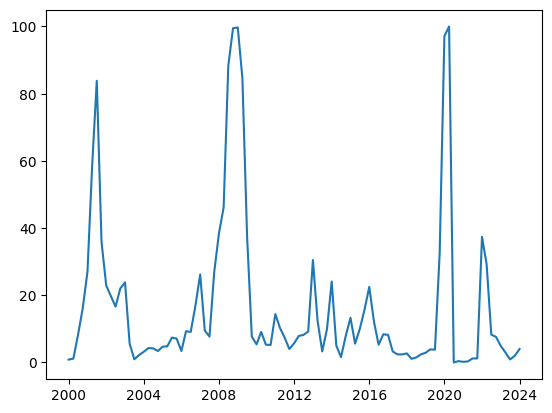

C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\3603618892.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["recession"].iloc[i] = 1
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\3603618892.py:24: SettingWithCopyWarning: 
A value 

In [20]:
recession_indicator_index = fred.get_series(series_id='JHGDPBRINDX', observation_start = '2000-01-01', observation_end='2024-01-01')
plt.figure()
plt.plot(recession_indicator_index)
plt.show()

recession_indicator_index = recession_indicator_index.copy()
recession_indicator_index = recession_indicator_index.to_frame(name='index')
recession_indicator_index.index = pd.to_datetime(recession_indicator_index.index)
recession_indicator_index = recession_indicator_index.resample('D').ffill()

def label_recessions(df):
    df = df.copy()
    df["recession"] = 0
    
    in_recession = False
    
    for i in range(len(df)):
        value = df["index"].iloc[i]
        
        if not in_recession:
            # recession starts
            if value > 67:
                in_recession = True
                df["recession"].iloc[i] = 1
        else:
            # currently in recession
            df["recession"].iloc[i] = 1
            
            # recession ends
            if value < 33:
                in_recession = False
    
    return df

fred_rec = label_recessions(recession_indicator_index)

In [21]:
fred_rec

,index,recession
2000-01-01,0.8612,0
2000-01-02,0.8612,0
2000-01-03,0.8612,0
2000-01-04,0.8612,0
2000-01-05,0.8612,0
...,...,...
2023-12-28,2.0000,0
2023-12-29,2.0000,0
2023-12-30,2.0000,0
2023-12-31,2.0000,0


In [22]:
fred_rec = fred_rec.reset_index()
fred_rec.columns = ['Date', 'index', 'recession']

# Make sure Date is datetime
fred_rec['Date'] = pd.to_datetime(fred_rec['Date'])
fred_rec.set_index('Date')

,index,recession
Date,,
2000-01-01,0.8612,0
2000-01-02,0.8612,0
2000-01-03,0.8612,0
2000-01-04,0.8612,0
2000-01-05,0.8612,0
...,...,...
2023-12-28,2.0000,0
2023-12-29,2.0000,0
2023-12-30,2.0000,0


In [23]:
def seperate_by_recession(results, recession):
    common_dates = results.index.intersection(recession.index)
    
    if len(common_dates) == 0:
        print("WARNING: No overlapping dates between results and recession!")
        return results.copy(), pd.DataFrame()
    
    # Filter regimes untuk tanggal yang ada di results
    recession_regimes = recession.loc[common_dates]
    
    # Separate
    non_recession_dates = recession_regimes[recession_regimes == 0].index
    recession_dates = recession_regimes[recession_regimes == 1].index
    
    non_recession_dates = results.loc[non_recession_dates].copy()
    recession_dates = results.loc[recession_dates].copy()
    
    print(f"\nFound {len(non_recession_dates)} non recession days")
    print(f"Found {len(recession_dates)} recession days")
    print(f"Total: {len(non_recession_dates) + len(recession_dates)} days")
    
    return recession_dates, non_recession_dates

In [24]:
def analyze_by_regime(recession_dates, non_recession_dates):
    """
    Analisis performance untuk masing-masing regime
    """
    print("\n" + "="*70)
    print("REGIME ANALYSIS - WALK-FORWARD RESULTS")
    print("="*70)
    
    total_days = len(non_recession_dates) + len(recession_dates)
    print(f"\nNon-Recession Days:  {len(non_recession_dates):>6} ({len(non_recession_dates)/total_days*100:>5.1f}%)")
    print(f"Recession Days: {len(recession_dates):>6} ({len(recession_dates)/total_days*100:>5.1f}%)")
    
    print("\n" + "-"*70)
    print(f"{'Metric':<35} {'Non-Recession':>15} {'Recession':>15}")
    print("-"*70)
    
    # Low Vol Stats
    if len(non_recession_dates) > 0:
        low_strat_ret = non_recession_dates['strategy_ret'].mean() * 252 * 100
        low_strat_vol = non_recession_dates['strategy_ret'].std() * np.sqrt(252) * 100
        low_strat_sharpe = non_recession_dates['strategy_ret'].mean() / non_recession_dates['strategy_ret'].std() * np.sqrt(252) if non_recession_dates['strategy_ret'].std() > 0 else 0
        low_bh_ret = non_recession_dates['ret'].mean() * 252 * 100
        low_bh_vol = non_recession_dates['ret'].std() * np.sqrt(252) * 100
        low_bh_sharpe = non_recession_dates['ret'].mean() / non_recession_dates['ret'].std() * np.sqrt(252) if non_recession_dates['ret'].std() > 0 else 0
        low_win = (non_recession_dates['strategy_ret'] > 0).sum() / len(non_recession_dates) * 100
        low_strat_total = (1 + non_recession_dates['strategy_ret']).prod() - 1
        low_bh_total = (1 + non_recession_dates['ret']).prod() - 1
    else:
        low_strat_ret = low_strat_vol = low_strat_sharpe = 0
        low_bh_ret = low_bh_vol = low_bh_sharpe = low_win = 0
        low_strat_total = low_bh_total = 0
    
    # High Vol Stats
    if len(recession_dates) > 0:
        high_strat_ret = recession_dates['strategy_ret'].mean() * 252 * 100
        high_strat_vol = recession_dates['strategy_ret'].std() * np.sqrt(252) * 100
        high_strat_sharpe = recession_dates['strategy_ret'].mean() / recession_dates['strategy_ret'].std() * np.sqrt(252) if recession_dates['strategy_ret'].std() > 0 else 0
        high_bh_ret = recession_dates['ret'].mean() * 252 * 100
        high_bh_vol = recession_dates['ret'].std() * np.sqrt(252) * 100
        high_bh_sharpe = recession_dates['ret'].mean() / recession_dates['ret'].std() * np.sqrt(252) if recession_dates['ret'].std() > 0 else 0
        high_win = (recession_dates['strategy_ret'] > 0).sum() / len(recession_dates) * 100
        high_strat_total = (1 + recession_dates['strategy_ret']).prod() - 1
        high_bh_total = (1 + recession_dates['ret']).prod() - 1
    else:
        high_strat_ret = high_strat_vol = high_strat_sharpe = 0
        high_bh_ret = high_bh_vol = high_bh_sharpe = high_win = 0
        high_strat_total = high_bh_total = 0
    
    print(f"{'Total Return (Strategy)':<35} {low_strat_total*100:>14.2f}% {high_strat_total*100:>14.2f}%")
    print(f"{'Total Return (Buy&Hold)':<35} {low_bh_total*100:>14.2f}% {high_bh_total*100:>14.2f}%")
    print(f"{'Ann. Return (Strategy)':<35} {low_strat_ret:>14.2f}% {high_strat_ret:>14.2f}%")
    print(f"{'Ann. Return (Buy&Hold)':<35} {low_bh_ret:>14.2f}% {high_bh_ret:>14.2f}%")
    print(f"{'Ann. Volatility (Strategy)':<35} {low_strat_vol:>14.2f}% {high_strat_vol:>14.2f}%")
    print(f"{'Ann. Volatility (Buy&Hold)':<35} {low_bh_vol:>14.2f}% {high_bh_vol:>14.2f}%")
    print(f"{'Sharpe Ratio (Strategy)':<35} {low_strat_sharpe:>15.2f} {high_strat_sharpe:>15.2f}")
    print(f"{'Sharpe Ratio (Buy&Hold)':<35} {low_bh_sharpe:>15.2f} {high_bh_sharpe:>15.2f}")
    print(f"{'Win Rate (Strategy)':<35} {low_win:>14.2f}% {high_win:>14.2f}%")
    
    print("="*70)

    

In [25]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

models = {}
all_results = {}

for ticker in asset_list:
    results = run_strategy_on_asset(ticker)
    all_results[ticker] = results
    market_ret = results['ret']
    # Fit on in-sample window
    model = MarkovRegression(
        market_ret,
        k_regimes=2,
        trend="c",
        switching_variance=True
    )

    models[ticker] = model.fit()
    


C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\128579421.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\i

In [26]:
all_results['SPY']

Price,signal,strategy_ret,ret
Ticker,,,
Date,,,
2003-01-03,-1.0,-0.003074,0.003074
2003-01-06,1.0,0.017625,0.017625
2003-01-07,1.0,-0.002474,-0.002474
2003-01-08,1.0,-0.014451,-0.014451
2003-01-09,1.0,0.015538,0.015538
...,...,...,...
2022-12-23,-1.0,-0.005752,0.005752
2022-12-27,-1.0,0.003944,-0.003944


In [27]:
for ticker in asset_list:
    print(f"\n{'='*70}")
    print(f"ASSET: {ticker}")
    print(f"{'='*70}")
    
    # Separate and analyze
    results = all_results[ticker]
    recession_dates, non_recession_dates = seperate_by_recession(results, fred_rec)
    analyze_by_regime(recession_dates, non_recession_dates)


ASSET: SPY

REGIME ANALYSIS - WALK-FORWARD RESULTS

Non-Recession Days:       0 (  0.0%)
Recession Days:   5034 (100.0%)

----------------------------------------------------------------------
Metric                                Non-Recession       Recession
----------------------------------------------------------------------
Total Return (Strategy)                       0.00%         -21.06%
Total Return (Buy&Hold)                       0.00%         516.35%
Ann. Return (Strategy)                        0.00%           0.65%
Ann. Return (Buy&Hold)                        0.00%          10.93%
Ann. Volatility (Strategy)                    0.00%          19.12%
Ann. Volatility (Buy&Hold)                    0.00%          19.11%
Sharpe Ratio (Strategy)                        0.00            0.03
Sharpe Ratio (Buy&Hold)                        0.00            0.57
Win Rate (Strategy)                           0.00%          48.93%

ASSET: QQQ

REGIME ANALYSIS - WALK-FORWARD RESULTS

No

In [28]:
for ticker in asset_list:
    print(f"\n{'='*70}")
    print(f"ASSET: {ticker}")
    print(f"{'='*70}")
    
    # Get regime from that asset's model
    regime = models[ticker].smoothed_marginal_probabilities.idxmax(axis=1)
    
    # Separate and analyze
    results = all_results[ticker]
    low_vol, high_vol = seperate_by_regimes(results, regime)
    analyze_by_regime(low_vol, high_vol)


ASSET: SPY

Found 3671 low volatility days
Found 1363 high volatility days
Total: 5034 days

REGIME ANALYSIS - WALK-FORWARD RESULTS

Non-Recession Days:    1363 ( 27.1%)
Recession Days:   3671 ( 72.9%)

----------------------------------------------------------------------
Metric                                Non-Recession       Recession
----------------------------------------------------------------------
Total Return (Strategy)                      80.88%         -56.36%
Total Return (Buy&Hold)                     -77.60%        2651.83%
Ann. Return (Strategy)                       16.18%          -5.12%
Ann. Return (Buy&Hold)                      -22.44%          23.33%
Ann. Volatility (Strategy)                   32.29%          10.68%
Ann. Volatility (Buy&Hold)                   32.27%          10.59%
Sharpe Ratio (Strategy)                        0.50           -0.48
Sharpe Ratio (Buy&Hold)                       -0.70            2.20
Win Rate (Strategy)                       

In [29]:
import statsmodels.api as sm

def newey_west_alpha_test(res):
    y = res['strategy_ret'] - res['ret']      # strategy excess over market
    X = np.ones(len(y))                       # constant only
    model = sm.OLS(y, X)
    nw = model.fit(cov_type='HAC', cov_kwds={'maxlags':5})
    return nw.tvalues[0], nw.pvalues[0]

for ticker in asset_list:
    results = all_results[ticker]
    t_values, p_values = newey_west_alpha_test(results)
    print(f"{ticker} t_values = {t_values}")
    print(f"{ticker} p_values = {p_values}")
    print("=" * 70)

SPY t_values = -1.7132334516464551
SPY p_values = 0.08666959979114915
QQQ t_values = -2.342479040949211
QQQ p_values = 0.019156109872066337
DIA t_values = -1.345747911923085
DIA p_values = 0.17838382900722816
EWJ t_values = -2.1220077539091844
EWJ p_values = 0.03383708691227894
EEM t_values = -1.2253173793997565
EEM p_values = 0.22045566274056227
VGK t_values = -1.2076439225538411
VGK p_values = 0.22718425673435327
TLT t_values = -1.233989135148956
TLT p_values = 0.21720695283945557
IEF t_values = -1.0128481275796273
IEF p_values = 0.3111327084563953
BND t_values = -1.2025847145497137
BND p_values = 0.22913706567695602
GLD t_values = -0.21133639360479822
GLD p_values = 0.8326247861926546
SLV t_values = -0.05419569161052516
SLV p_values = 0.956779253238527
USO t_values = 1.1382832052740564
USO p_values = 0.25500224457912535
EURUSD=X t_values = -0.9236633058388319
EURUSD=X p_values = 0.35566164251213395
JPY=X t_values = -1.2809649650841752
JPY=X p_values = 0.2002059722038224
AUDUSD=X t_v

C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pvalues[0]
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pvalues[0]
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pva

In [30]:
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests(series):
    return {
        'adf_p': adfuller(series.dropna())[1],
        'kpss_p': kpss(series.dropna(), nlags='auto')[1]
    }

for ticker in asset_list:
    results = all_results[ticker]
    adf_p, kpps_p = newey_west_alpha_test(results)
    print(f"{ticker} adf p_value = {adf_p}")
    print(f"{ticker} kpps p_value = {kpps_p}")
    print("=" * 70)

SPY adf p_value = -1.7132334516464551
SPY kpps p_value = 0.08666959979114915
QQQ adf p_value = -2.342479040949211
QQQ kpps p_value = 0.019156109872066337
DIA adf p_value = -1.345747911923085
DIA kpps p_value = 0.17838382900722816
EWJ adf p_value = -2.1220077539091844
EWJ kpps p_value = 0.03383708691227894
EEM adf p_value = -1.2253173793997565
EEM kpps p_value = 0.22045566274056227
VGK adf p_value = -1.2076439225538411
VGK kpps p_value = 0.22718425673435327
TLT adf p_value = -1.233989135148956
TLT kpps p_value = 0.21720695283945557
IEF adf p_value = -1.0128481275796273
IEF kpps p_value = 0.3111327084563953
BND adf p_value = -1.2025847145497137
BND kpps p_value = 0.22913706567695602
GLD adf p_value = -0.21133639360479822
GLD kpps p_value = 0.8326247861926546
SLV adf p_value = -0.05419569161052516
SLV kpps p_value = 0.956779253238527
USO adf p_value = 1.1382832052740564
USO kpps p_value = 0.25500224457912535
EURUSD=X adf p_value = -0.9236633058388319
EURUSD=X kpps p_value = 0.355661642512

C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pvalues[0]
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pvalues[0]
C:\Users\Sebas\AppData\Local\Temp\ipykernel_2784\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pva

In [31]:
import numpy as np
from scipy.stats import norm

def ledoit_wolf_sharpe_test(r1, r2):
    n = len(r1)
    mean1, mean2 = np.mean(r1), np.mean(r2)
    std1, std2  = np.std(r1, ddof=1), np.std(r2, ddof=1)

    sharpe1, sharpe2 = mean1/std1, mean2/std2
    diff = sharpe1 - sharpe2

    # LW correction components
    term1 = (mean1**2 / (2 * std1**4)) * np.var((r1 - mean1)**2)
    term2 = (mean2**2 / (2 * std2**4)) * np.var((r2 - mean2)**2)
    var_diff = term1 + term2

    z = diff / np.sqrt(var_diff / n)
    p = 1 - norm.cdf(z)  # one-sided test: is Sharpe1 > Sharpe2?

    return sharpe1, sharpe2, diff, z, p

for ticker in asset_list:
    results = all_results[ticker]
    s1, s2, diff, z, p = ledoit_wolf_sharpe_test(results['strategy_ret'], results['ret'])
    print(f'p value for {ticker} = {p}')

p value for SPY = 1.0
p value for QQQ = 1.0
p value for DIA = 1.0
p value for EWJ = 1.0
p value for EEM = 1.0
p value for VGK = 1.0
p value for TLT = 1.0
p value for IEF = 1.0
p value for BND = 1.0
p value for GLD = 1.0
p value for SLV = 1.0
p value for USO = 0.0
p value for EURUSD=X = 1.0
p value for JPY=X = 1.0
p value for AUDUSD=X = 0.0
p value for BTC-USD = 3.7464596730263366e-05
p value for ETH-USD = 1.0


In [32]:
import numpy as np

def bootstrap_significance(strategy_returns, n_boot=5000):
    actual_mean = np.mean(strategy_returns)

    boot_means = []
    for _ in range(n_boot):
        random_sign = np.random.choice([-1, 1], size=len(strategy_returns))
        boot_means.append(np.mean(strategy_returns * random_sign))

    p_value = np.mean(np.array(boot_means) >= actual_mean)
    return actual_mean, np.mean(boot_means), p_value

for ticker in asset_list:
    results = all_results[ticker]
    actual_mean, boot_mean, p_value = bootstrap_significance(results['strategy_ret'])
    print(f'{ticker} p_value = {p_value}')


SPY p_value = 0.4312
QQQ p_value = 0.5754
DIA p_value = 0.2432
EWJ p_value = 0.933
EEM p_value = 0.7234
VGK p_value = 0.7736
TLT p_value = 0.5896
IEF p_value = 0.2136
BND p_value = 0.4056
GLD p_value = 0.0986
SLV p_value = 0.1502
USO p_value = 0.081
EURUSD=X p_value = 0.8924
JPY=X p_value = 0.9078
AUDUSD=X p_value = 0.3434
BTC-USD p_value = 0.0174
ETH-USD p_value = 0.323
